In [2]:
import numpy as np
import pandas as pd

### Preparing the dataset

In [350]:
# data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv'

In [351]:
# !wget $data

In [352]:
df = pd.read_csv('laptops.csv')

In [353]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [270]:
df.head()

,laptop,status,brand,model,cpu,ram,storage,storage_type,gpu,screen,touch,final_price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [354]:
columns = ['ram', 'storage', 'screen']

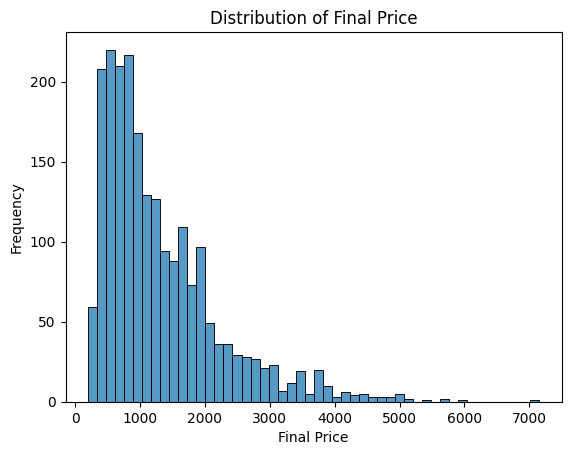

In [355]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['final_price'], bins=50)
plt.xlabel('Final Price')
plt.ylabel('Frequency')
plt.title('Distribution of Final Price')
plt.show()

<Axes: xlabel='final_price', ylabel='Count'>

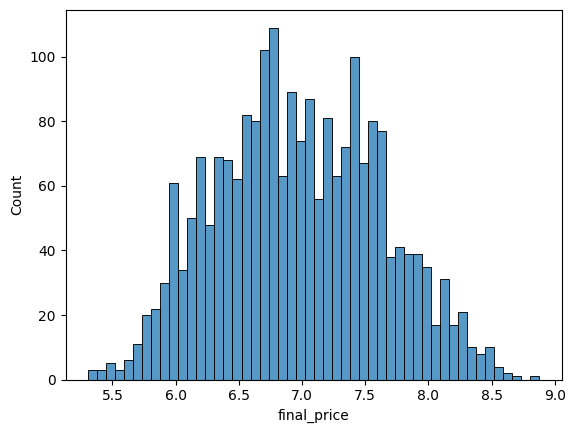

In [356]:
final_price = np.log1p(df.final_price)
sns.histplot(final_price, bins=50)

### Q1

In [357]:
df[columns].isnull().sum()

ram        0
storage    0
screen     4
dtype: int64

### Q2

In [358]:
min_ram = df['ram'].min()
median_ram = df['ram'].median()
max_ram = df['ram'].max()
print(f"The median RAM is: {median_ram} in range: {min_ram} ~ {max_ram}")

The median RAM is: 16.0 in range: 4 ~ 128


In [359]:
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [422]:
def split_and_reset_data(sd):
    idx = np.arange(n)
    np.random.seed(sd)
    np.random.shuffle(idx)
    
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    return df_train, df_val, df_test

In [423]:
def handle_final_price(df):
    y = np.log1p(df['final_price'].values)
    
    del df['final_price']
    
    return y

In [428]:
df_train, df_val, df_test = split_and_reset_data(42)
y_train = handle_final_price(df_train)
y_val = handle_final_price(df_val)
y_test = handle_final_price(df_test)

### Q3

In [402]:
df_train.iloc[12]

laptop          HP 470 G9 Intel Core i5-1235U/16GB/512GB SSD/M...
status                                                        New
brand                                                          HP
model                                                         470
cpu                                                 Intel Core i5
ram                                                            16
storage                                                       512
storage_type                                                  SSD
gpu                                                        MX 550
screen                                                       17.3
touch                                                          No
Name: 12, dtype: object

In [404]:
xi = [8, 512, 15.6]

In [405]:
w0 = 0.7
w = [0.02, 0.01, 0.005]

In [406]:
def dot(xi, w):
    n = len(xi)
    res = 0.0
    for j in range(n):
        res = res + xi[j] * w[j]
    return res

In [407]:
w_new = [w0] + w
def linear_regression(xi):
    xi = [1] + xi
    return dot(xi, w_new)

In [408]:
pred_value = linear_regression(xi)
pred_value

6.058000000000001

In [409]:
y_train[12]

np.float64(7.10085190894405)

In [410]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [411]:
rmse(y_train[12], pred_value)

np.float64(1.0428519089440496)

In [372]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [412]:
# filling nan value without changing original data frame
def prepare_X(df, f_v=0):
    df_values = df[columns].fillna(f_v).values
    return df_values

In [432]:
f_v = 0
# f_v = df['screen'].mean()
f_v

0

In [433]:
# train using df_train
X_train = prepare_X(df_train, f_v)
w0, w = train_linear_regression(X_train, y_train)

# validate using df_val
X_val = prepare_X(df_val, f_v)
y_pred = w0 + X_val.dot(w)
rms = rmse(y_val, y_pred)
round(rms, 2)

np.float64(0.43)

### Q4

In [322]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]

In [326]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train = prepare_X(df_train, 0)
    w0, w = train_linear_regression_reg(X_train, y_train, r)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)

    rms = rmse(y_val, y_pred)
    print(f"when r is: {r}, rmse is: {round(rms, 2)}")

when r is: 0, rmse is: 0.43
when r is: 0.01, rmse is: 0.43
when r is: 0.1, rmse is: 0.43
when r is: 1, rmse is: 0.43
when r is: 5, rmse is: 0.46
when r is: 10, rmse is: 0.51
when r is: 100, rmse is: 0.67


### Q5

In [414]:
result = []
for sd in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    df_train, df_val, df_test = split_and_reset_data(sd)
    
    y_train = handle_final_price(df_train)
    y_val = handle_final_price(df_val)

    # train using df_train
    X_train = prepare_X(df_train, 0)
    w0, w = train_linear_regression(X_train, y_train)

    # validate using df_val
    X_val = prepare_X(df_val, 0)
    y_pred = w0 + X_val.dot(w)
    rms = rmse(y_val, y_pred)
    result.append(rms)
result

[np.float64(0.43004215694158965),
 np.float64(0.4520794495247242),
 np.float64(0.4462625574236662),
 np.float64(0.4464515565727131),
 np.float64(0.4199805419364144),
 np.float64(0.4254576323418724),
 np.float64(0.4488322872387867),
 np.float64(0.4309159875904646),
 np.float64(0.4428849183283987),
 np.float64(0.40840334262399886)]

In [416]:
round(np.std(result), 3)

np.float64(0.014)

### Q6

In [421]:
df_train, df_val, df_test = split_and_reset_data(9)

y_train = handle_final_price(df_train)
y_val = handle_final_price(df_val)
y_test = handle_final_price(df_test)

df_full_train = pd.concat([df_train, df_val])
X_full_train = prepare_X(df_full_train)

y_full_train = np.concatenate([y_train, y_val])

w0, w = train_linear_regression_reg(X_full_train, y_full_train, 0.001)

X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)

rms = rmse(y_test, y_pred)
rms

np.float64(0.4553047228090914)